In [1]:
import scanpy as sc
import numpy as np
import pandas as pd


In [2]:
adata = sc.read("/storage/users/sac43cg/res_Samantha_1/outs/h5as_files/combined_adata.h5ad")  # Replace with your data file

In [3]:
print(adata)

AnnData object with n_obs × n_vars = 11919 × 36613
    obs: 'condition'


In [4]:
sc.pp.filter_cells(adata, min_genes=200)   # Filter cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells=3)     # Filter genes expressed in fewer than 3 cells

In [5]:
# Step 3: Normalization
sc.pp.normalize_total(adata, target_sum=1e4)

In [6]:
sc.pp.log1p(adata)  # Apply log(1+x) transformation

In [7]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=2000)

In [8]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

AnnData object with n_obs × n_vars = 11004 × 26832
    obs: 'condition', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'hvg'


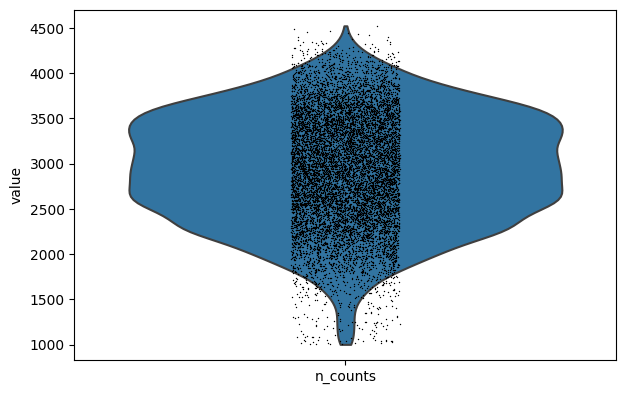

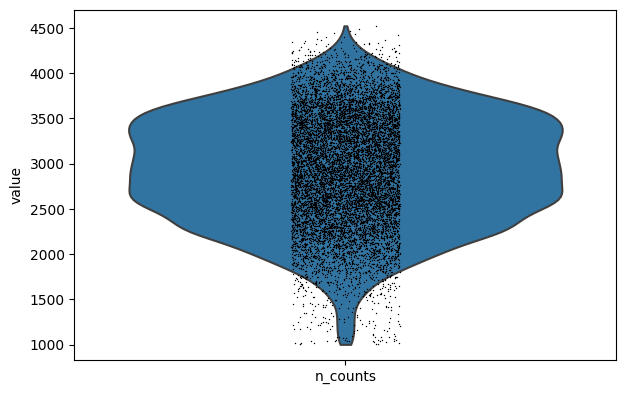

In [9]:
# Step 1: Cell Filtering
sc.pp.filter_cells(adata, min_counts=1000)

print(adata)
sc.pl.violin(adata, keys=['n_counts'], jitter=True, log=False)
sc.pl.violin(adata, keys=['n_counts'], jitter=True, log=False, save="_preprocessing.png")

In [10]:
# Step 4: Gene Dispersion Filtering
sc.pp.filter_genes_dispersion(adata, min_disp=0.5)

In [11]:
# Update the counts matrix and genes list
adata = adata[:, adata.var.highly_variable]

In [12]:
# Step 2: Mitochondrial Gene Filtering
mito_genes = adata.var_names.str.startswith('MT-')
percent_mito = adata[:, mito_genes].X.sum(axis=1) / adata.X.sum(axis=1)
cells_to_keep = percent_mito <= 0.05

# Calculate percent ribosomal genes
ribo_genes = adata.var_names.str.startswith('RP')
percent_ribo = adata[:, ribo_genes].X.sum(axis=1) / adata.X.sum(axis=1)


In [13]:
# Update AnnData with new attributes
adata.obs['percent_mito'] = percent_mito
adata.obs['percent_ribo'] = percent_ribo

/tmp/ipykernel_453313/1036801892.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['percent_mito'] = percent_mito


/home/sac43cg/miniconda3/envs/Gudruns_PDAC/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


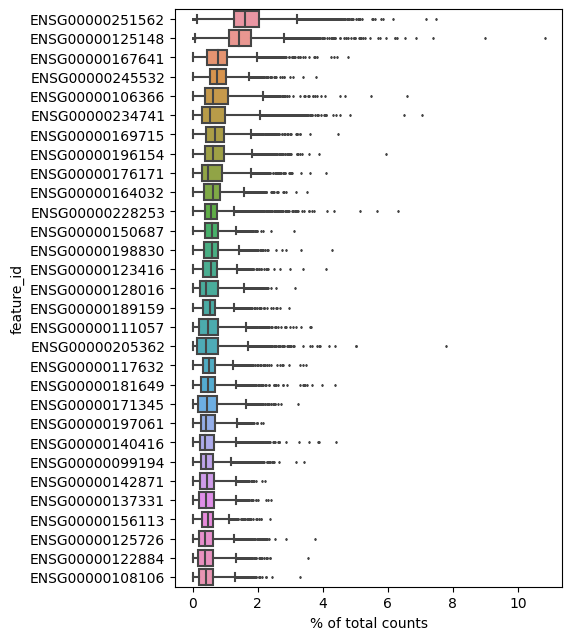

In [14]:
# Entfernen von "CMO" aus dem Index von adata.var
cmo_entries = [index for index in adata.var.index if index.startswith("CMO")]
adata = adata[:, ~adata.var.index.isin(cmo_entries)]

# Erstellen Sie Ihren Plot mit den aktualisierten Daten
sc.pl.highest_expr_genes(adata)  # Ersetzen Sie "some_plot" durch den tatsächlichen Namen Ihres Plots


In [15]:
# Speichern des bearbeiteten Datensatzes
adata.write_h5ad('/storage/users/sac43cg/res_Samantha_1/outs/h5as_files/adata_neu.h5ad')

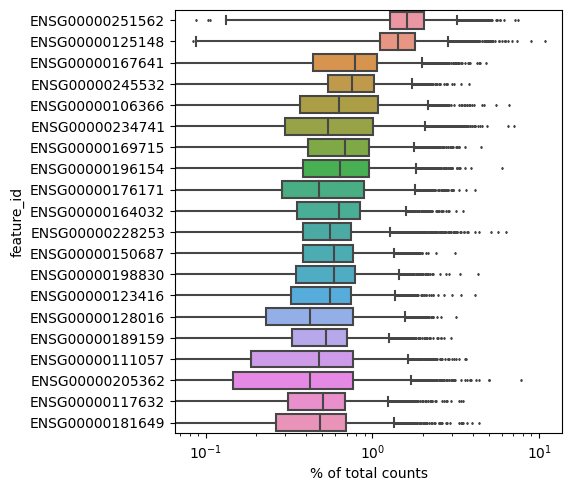

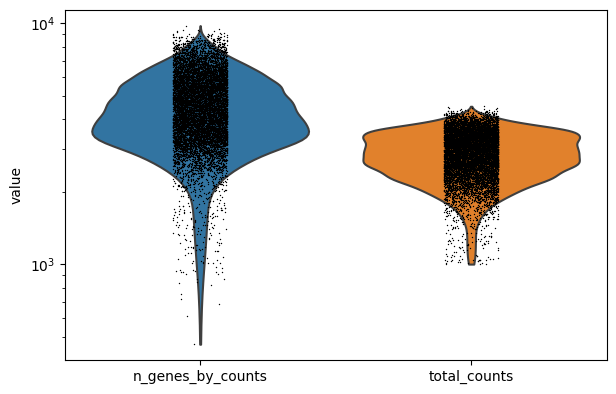

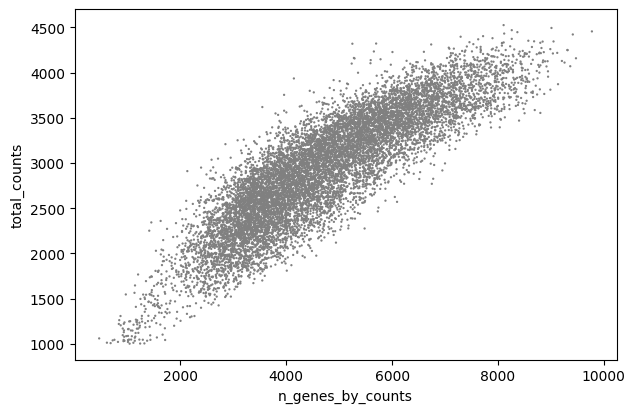

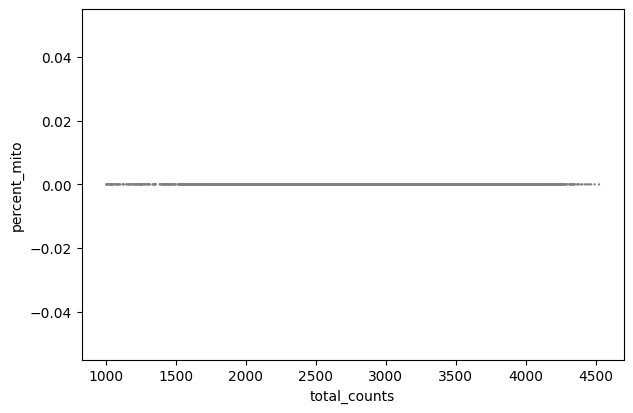

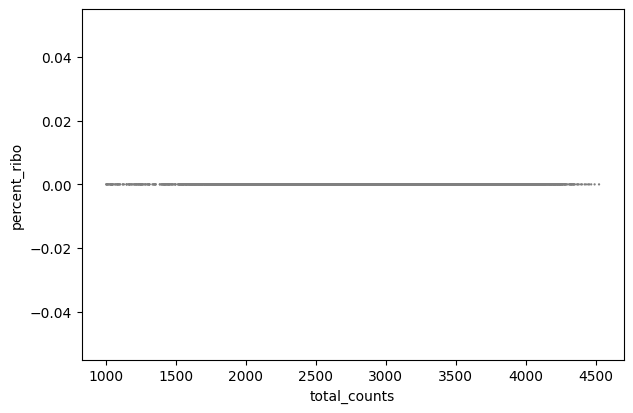

In [16]:
# Visualize QC results
sc.pl.highest_expr_genes(adata, n_top=20, log=True, save='_qc.png')
sc.pl.violin(adata, keys=['n_genes_by_counts', 'total_counts'], jitter=True, log=True, save='_qc.png')
sc.pl.scatter(adata, x='n_genes_by_counts', y='total_counts', save='_qc.png')
sc.pl.scatter(adata, x='total_counts', y='percent_mito', save='_qc.png')
sc.pl.scatter(adata, x='total_counts', y='percent_ribo', save='_qc.png')

#Make sure that the percent_mito and percent_ribo attributes are correctly calculated and added to the .obs attribute of your AnnData object before using them in the plotting functions.

In [17]:
import pandas as pd
import requests

# Pfad zur DEG-Datei
deg_file_path = '/storage/users/sac43cg/res_Samantha_1/outs/DEGs/CTRL_1_vs_CTRL_2D/differentially_expressed_genes.txt'

# Datei laden
deg_data = pd.read_csv(deg_file_path, sep='\t', header=None)

# Gen-IDs aus der Datei extrahieren
deg_gene_ids = deg_data.iloc[:, 0]

# Ensembl-REST-API-URL für die Konvertierung von Ensembl-Gene-IDs in Gene-Namen
url = "https://rest.ensembl.org/lookup/id"

# Gen-Namen abfragen und in ein Dictionary speichern
gene_id_to_name = {}
for gene_id in deg_gene_ids:
    response = requests.get(f"{url}/{gene_id}", headers={"Content-Type": "application/json"})
    data = response.json()
    if "display_name" in data:
        gene_id_to_name[gene_id] = data["display_name"]

# Übersetzen der Gen-IDs in Gen-Namen in Ihrer DEG-Datei
deg_data['gene_name'] = deg_data.iloc[:, 0].map(gene_id_to_name)

# Filtern der Daten, um Zeilen mit fehlenden Gen-Namen oder "MT-" zu entfernen
filtered_deg_data = deg_data.dropna(subset=['gene_name'])
filtered_deg_data = filtered_deg_data[~filtered_deg_data['gene_name'].str.startswith("MT-")]

# Ausgabe der gefilterten DEG-Daten mit Gen-Namen
print(filtered_deg_data)
# Pfad zum Ausgabe-Datei
output_file_path = '/storage/users/sac43cg/res_Samantha_1/outs/DEGs/CTRL_1_vs_CTRL_2D/filtered_DEGs_with_names.csv'

# Speichern der gefilterten DEG-Daten in einer CSV-Datei
filtered_deg_data.to_csv(output_file_path, index=False)


                    0         1 gene_name
0     ENSG00000164032  2.475180     H2AZ1
1     ENSG00000197451  2.333972   HNRNPAB
2     ENSG00000101361  1.988561     NOP56
3     ENSG00000203760  2.511373     CENPW
4     ENSG00000119969  2.848776     HELLS
...               ...       ...       ...
1123  ENSG00000170345 -5.866974       FOS
1124  ENSG00000122884 -2.568223     P4HA1
1125  ENSG00000176171 -2.340556     BNIP3
1126  ENSG00000120738 -4.969254      EGR1
1127  ENSG00000234741 -2.770039      GAS5

[1083 rows x 3 columns]


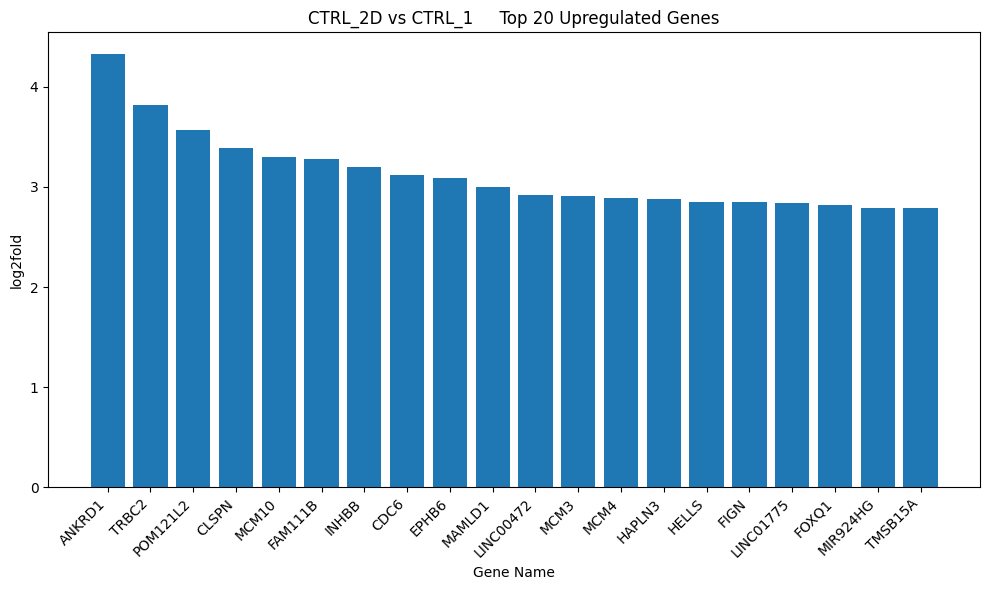

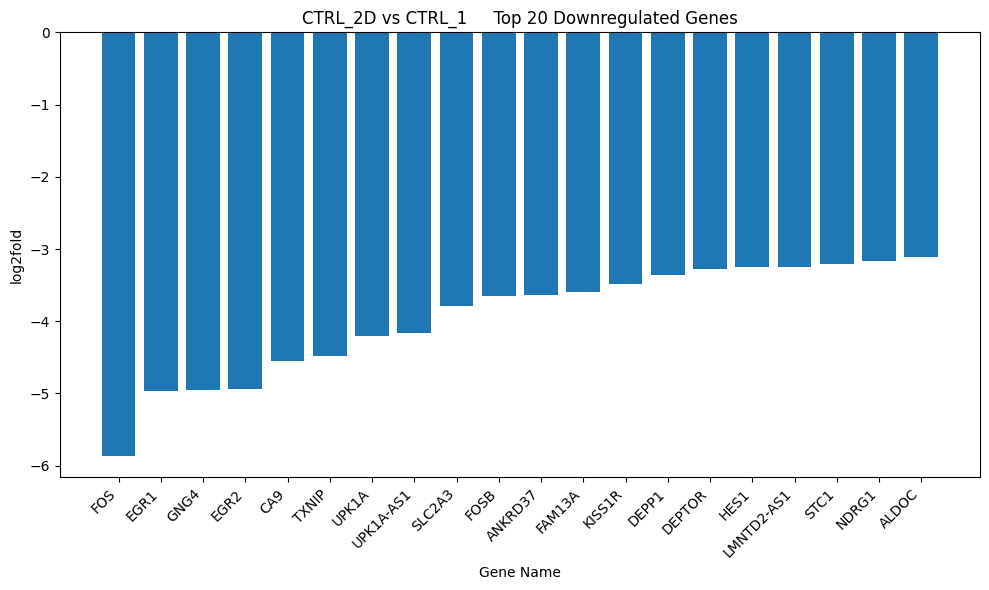

In [18]:
import os
import matplotlib.pyplot as plt

# Ersetze 'dein/verzeichnis/pfad' durch den gewünschten Pfad auf deinem System
output_directory = '/storage/users/sac43cg/res_Samantha_1/outs/DEGs/CTRL_1_vs_CTRL_2D/'

# Erstellen eines Verzeichnisses für die Plots, falls es nicht existiert
plots_directory = os.path.join(output_directory, 'plots')
if not os.path.exists(plots_directory):
    os.makedirs(plots_directory)

# Sortieren der Daten nach Expression Value
sorted_upregulated = filtered_deg_data[filtered_deg_data[1] > 0].sort_values(by=1, ascending=False).head(20)
sorted_downregulated = filtered_deg_data[filtered_deg_data[1] < 0].sort_values(by=1, ascending=True).head(20)

# Erstellen eines Bar-Plots der Top 20 hochregulierten Gene
plt.figure(figsize=(10, 6))
plt.bar(sorted_upregulated['gene_name'], sorted_upregulated[1])
plt.xlabel('Gene Name')
plt.ylabel('log2fold')
plt.title('CTRL_2D vs CTRL_1     Top 20 Upregulated Genes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Speichern des Plots im Verzeichnis
upregulated_plot_path = os.path.join(plots_directory, 'upregulated_genes_plot.png')
plt.savefig(upregulated_plot_path)

# Erstellen eines Bar-Plots der Top 20 herunterregulierten Gene
plt.figure(figsize=(10, 6))
plt.bar(sorted_downregulated['gene_name'], sorted_downregulated[1])
plt.xlabel('Gene Name')
plt.ylabel('log2fold')
plt.title('CTRL_2D vs CTRL_1     Top 20 Downregulated Genes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Speichern des Plots im Verzeichnis
downregulated_plot_path = os.path.join(plots_directory, 'downregulated_genes_plot.png')
plt.savefig(downregulated_plot_path)

# Anzeigen der Plots
plt.show()


In [49]:
import pandas as pd
import requests

# Pfad zur DEG-Datei
deg_file_path = '/storage/users/sac43cg/res_Samantha_1/outs/DEGs/CTRL_1_vs_CTRL_2D/differentially_expressed_genes.txt'

# Datei laden
deg_data = pd.read_csv(deg_file_path, sep='\t', header=None)

# Gen-IDs aus der Datei extrahieren
deg_gene_ids = deg_data.iloc[:, 0]

# Ensembl-REST-API-URL für die Konvertierung von Ensembl-Gene-IDs in Gene-Namen
url = "https://rest.ensembl.org/lookup/id"

# Gen-Namen abfragen und in ein Dictionary speichern
gene_id_to_name = {}
for gene_id in deg_gene_ids:
    response = requests.get(f"{url}/{gene_id}", headers={"Content-Type": "application/json"})
    data = response.json()
    if "display_name" in data:
        gene_id_to_name[gene_id] = data["display_name"]

# Übersetzen der Gen-IDs in Gen-Namen in Ihrer DEG-Datei
deg_data['gene_name'] = deg_data.iloc[:, 0].map(gene_id_to_name)

# Filtern der Daten, um Zeilen mit fehlenden Gen-Namen oder "MT-" zu entfernen
filtered_deg_data = deg_data.dropna(subset=['gene_name'])
filtered_deg_data = filtered_deg_data[~filtered_deg_data['gene_name'].str.startswith("MT-")]


     gene_identifiers  log2fold_changes gene_name
0     ENSG00000164032          2.475180     H2AZ1
1     ENSG00000197451          2.333972   HNRNPAB
2     ENSG00000101361          1.988561     NOP56
3     ENSG00000203760          2.511373     CENPW
4     ENSG00000119969          2.848776     HELLS
...               ...               ...       ...
1123  ENSG00000170345         -5.866974       FOS
1124  ENSG00000122884         -2.568223     P4HA1
1125  ENSG00000176171         -2.340556     BNIP3
1126  ENSG00000120738         -4.969254      EGR1
1127  ENSG00000234741         -2.770039      GAS5

[1083 rows x 3 columns]


In [50]:
import pandas as pd

# Annahme: Du hast bereits die Spalten umbenannt
filtered_deg_data.columns = ['gene_identifiers', 'log2fold_changes', 'gene_name']

# Annahme: Du hast die Daten im DataFrame "filtered_deg_data" geladen und gefiltert

# Ausgabe der gefilterten DEG-Daten mit den neuen Spaltennamen
print(filtered_deg_data)

# Pfad zur Ausgabedatei
output_file_path = '/storage/users/sac43cg/res_Samantha_1/outs/DEGs/CTRL_1_vs_CTRL_2D/filtered_DEGs_with_names.csv'

# Speichern der gefilterten DEG-Daten in einer CSV-Datei
filtered_deg_data.to_csv(output_file_path, index=False)


     gene_identifiers  log2fold_changes gene_name
0     ENSG00000164032          2.475180     H2AZ1
1     ENSG00000197451          2.333972   HNRNPAB
2     ENSG00000101361          1.988561     NOP56
3     ENSG00000203760          2.511373     CENPW
4     ENSG00000119969          2.848776     HELLS
...               ...               ...       ...
1123  ENSG00000170345         -5.866974       FOS
1124  ENSG00000122884         -2.568223     P4HA1
1125  ENSG00000176171         -2.340556     BNIP3
1126  ENSG00000120738         -4.969254      EGR1
1127  ENSG00000234741         -2.770039      GAS5

[1083 rows x 3 columns]


In [29]:
adata.obs.head()

,condition,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_counts,percent_mito,percent_ribo
barcode,,,,,,,,,,,,,
AAACCCAGTAGGCTCC-1,CTRL_1,3084,3084,8.034307,2306.376221,7.743866,9.144341,15.927431,25.299345,42.278638,2306.376221,0.0,0.0
AAACCCAGTCGCAACC-1,CTRL_1,4279,4279,8.361708,2477.537109,7.815424,7.880601,13.525613,21.139233,35.308095,2477.537109,0.0,0.0
AAACCCATCCACAAGT-1,CTRL_1,3525,3525,8.167919,2703.020996,7.902495,7.380460,12.715844,20.955914,37.171148,2703.020996,0.0,0.0
AAACGCTTCACTACGA-1,CTRL_1,4085,4085,8.315322,2685.781250,7.896099,7.550919,13.110586,21.108725,35.881412,2685.781250,0.0,0.0
AAACGCTTCAGCCTCT-1,CTRL_1,6271,6271,8.743851,3086.966553,8.035268,6.417625,11.132270,17.742240,30.294201,3086.966553,0.0,0.0


In [21]:
print(adata)

AnnData object with n_obs × n_vars = 11004 × 1123
    obs: 'condition', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'percent_mito', 'percent_ribo'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'hvg'


In [30]:
import pandas as pd
import requests
import scanpy as sc

# Annahme: adata ist Ihr vorhandenes anndata-Objekt

# Pfad zur DEG-Datei
deg_file_path = '/storage/users/sac43cg/res_Samantha_1/outs/DEGs/CTRL_1_vs_CTRL_2D/filtered_DEGs_with_names.csv'

# Datei laden
deg_data = pd.read_csv(deg_file_path)

# Extrahieren der Gen-IDs und Gen-Namen aus der DEG-Datei
gene_ids = deg_data['gene_identifiers']
gene_names = deg_data['gene_name']

# Erstellen eines leeren Dictionaries für die Zuordnung von Ensembl-IDs zu Gen-Namen
gene_id_to_name = dict(zip(gene_ids, gene_names))

# Hinzufügen der Gen-Namen zu den adata-Metadaten
adata.var['gene_names'] = adata.var.index.map(gene_id_to_name)

# Jetzt enthält adata.var['gene_names'] die zugehörigen Gen-Namen

# Beispiel: Zugriff auf die Gen-Namen für die ersten 10 Gene im adata
print(adata.var['gene_names'][:10])

feature_id
ENSG00000184163     C1QTNF12
ENSG00000162576        MXRA8
ENSG00000235169        SMIM1
ENSG00000238290    ERRFI1-DT
ENSG00000180758       GPR157
ENSG00000162444         RBP7
ENSG00000189337         KAZN
ENSG00000117122        MFAP2
ENSG00000159363      ATP13A2
ENSG00000117115        PADI2
Name: gene_names, dtype: object


In [31]:
print(adata)

AnnData object with n_obs × n_vars = 11004 × 1123
    obs: 'condition', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'percent_mito', 'percent_ribo'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_names'
    uns: 'log1p', 'hvg', 't-test'


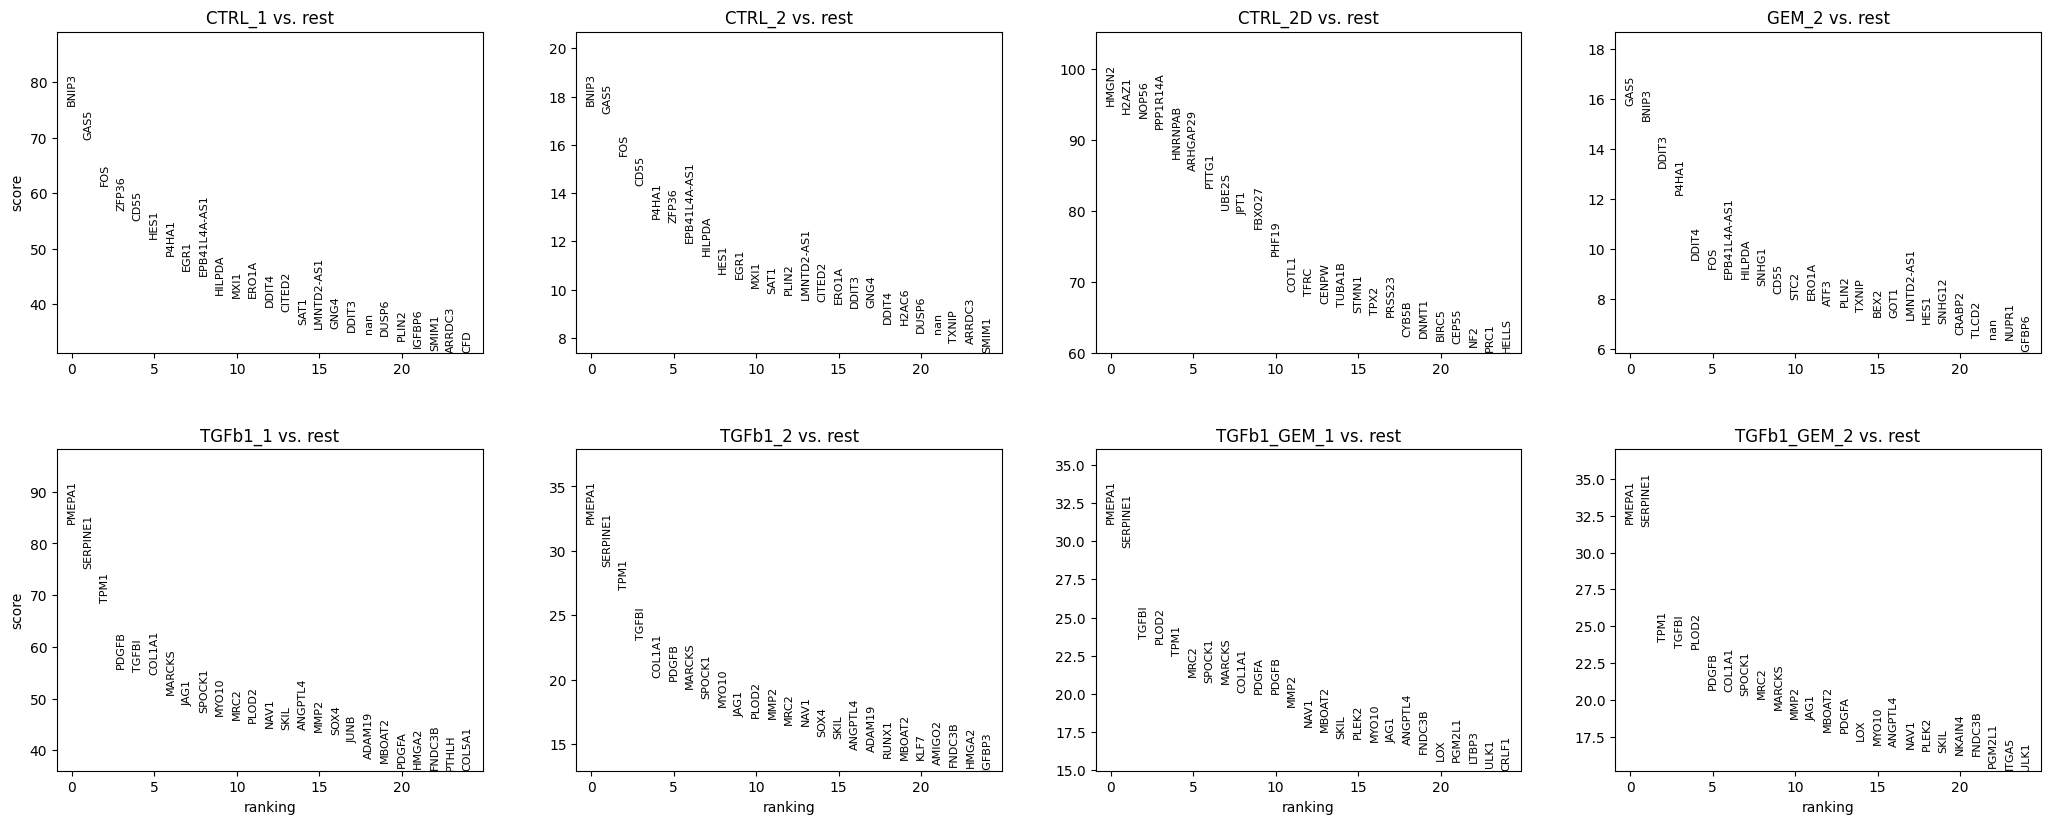

In [36]:
sc.tl.rank_genes_groups(adata, 'condition', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="t-test", gene_symbols='gene_names',log=True, xlabel="Log2 Fold Change", ylabel="Negative Log10 p-value")


In [48]:

sc.tl.rank_genes_groups(adata, groupby="leiden", method='t-test', key_added="rank_genes_leiden")
sc.pl.rank_genes_groups(adata, groupy='leiden', n_genes=25, sharey=False, key="t-test", gene_symbols='gene_names',log=True, xlabel="Log2 Fold Change", ylabel="Negative Log10 p-value")


KeyError: 'leiden'